Throughout this document the following imports and styles are used.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Observations

A list of observations that are made for the strategy, but have not yet found a place in this document:

* When the market is moving sides there is low volatility. Because there is low volatility the points $a$ and $b$ for the Fibonacci tool are closely together. This creates very poor setups and we should not trade those. If we do ignore them, this strategy will not trade when there is no volatility.


* If we have the following situation: we are in a position, and a signal tells us to trade into the opposite direction. However, the setup is too small percentage-wise to trade. We might still want to use this as an exit signal, and close our current position.

# Goal

The goal is to create backtesting algorithm for automated trading strategies. It should be easy to implement new strategies to gain statistical insight in the performance of that strategy.

It should also be possible to have a framework for parameter optimization. It should be taken into account that running a simulation can take quite some time. Due to multiple parameters this quickly leads into a combinatorial explosion, which should be accounted for.

The simulation should implement market trading as realistically as possible. Therefore it would use a balance to have the exponential growth of equity. Keep track of fees that are paid, and are subtracted from the position costs/gains. 

Risk management should also be implemented. We want to simulate the strategies using different leverage, position sizes, and stop loss percentage. It should also be possible to place stop losses based on calculations, thus not always a fixed-percentage stop loss.

# Libraries

In this document we will be using open-source Python libraries, and customly developed libraries to perform technical analysis.

## General libraries

The open-source libraries that this document uses are:

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from matplotlib import gridspec

## Custom libraries

The custom libraries are developed specifically for the framework. Let's load them into this document:

In [3]:
import poloniex as plnx
import ta_lib as ta

# Data

Currently we are using the data that is supplied by Poloniex. There is a customly developed API that we can use to quickly fetch chart data.

The API does not support the 1 hour timeframe, thus we have to make this ourselves. This can be done by combining the data in a 30 minute candles into 1 hour candles. The new values will be:

 * **Open:** Open of the first candle
 * **Close**: Close of the second candle
 * **High**: Max of both candles high
 * **Low**: Min of both candles low

This should be encapsulated in the Poloniex API library.

## Chart data

We will be using the `USDT_BTC` trading pair. To fetch the data from the API:

In [4]:
pair = 'USDT_BTC'
timeframe = 15 * 60
end = datetime.utcnow()
start = end - timedelta(days=31)
chart = plnx.get_chart(pair, timeframe, start, end)
chart.tail()

,close,date,high,low,open
2971,8387.905948,2018-05-21 22:15:00,8400.000000,8381.000000,8388.569741
2972,8415.754369,2018-05-21 22:30:00,8440.000000,8390.000000,8400.000000
2973,8408.000000,2018-05-21 22:45:00,8419.114528,8396.041699,8415.754369
2974,8399.288533,2018-05-21 23:00:00,8409.000000,8396.405210,8408.000000
2975,8399.925460,2018-05-21 23:15:00,8418.749807,8399.288533,8407.000000


Plotting the data gives us:

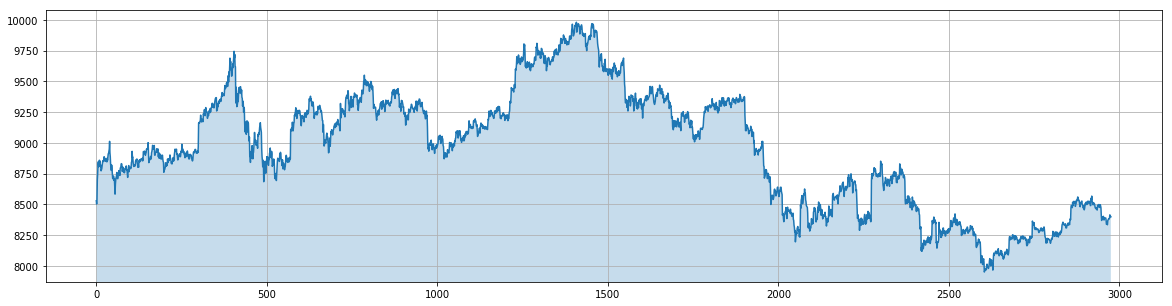

In [5]:
plt.figure(figsize=(20,5))
plt.plot(chart['close'])
plt.fill_between(chart.index, chart['close'], alpha=0.25)
plt.ylim(0.99*chart['close'].min(), 1.01*chart['close'].max())
plt.grid()

## Technical indicators

The library `ta_lib` supports the following technical indicators:

 * SMA
 * WMA
 * EMA
 * Bollinger Bands
 * RSI
 
We can append the technical indicators to the chart data in this way:

In [6]:
ta.ema(chart, 8)
ta.ema(chart, 21)
ta.ema(chart, 55)
chart.tail()

,close,date,high,low,open,ema8,ema21,ema55
2971,8387.905948,2018-05-21 22:15:00,8400.000000,8381.000000,8388.569741,8378.551453,8374.072971,8412.001039
2972,8415.754369,2018-05-21 22:30:00,8440.000000,8390.000000,8400.000000,8389.904330,8378.485061,8411.405017
2973,8408.000000,2018-05-21 22:45:00,8419.114528,8396.041699,8415.754369,8396.453731,8381.449713,8410.585823
2974,8399.288533,2018-05-21 23:00:00,8409.000000,8396.405210,8408.000000,8398.010656,8383.089066,8409.254140
2975,8399.925460,2018-05-21 23:15:00,8418.749807,8399.288533,8407.000000,8399.156944,8384.740167,8408.220805


## Entries and exits

We will append a few columns to the data frame which are used for the entries and exits that are generated from the signals. The simulation should only use these columns to determine what to do. The exact position sizes are calculated in the simulation because we want to use different risk management strategies.

When we implement the strategy we will have to generate that signals, and use those signals to indicate when we have to open a position. When we already have a position open, and we get an open signal for the other direction, we close the previous position. 

In [7]:
chart['open_long'] = chart['open_short'] = 0

We also want to be able to only close a position without opening a new one. Therefore we add the following columns:

In [8]:
chart['close_long'] = chart['close_short'] = 0

Our data frame now looks like this:

In [9]:
chart.tail()

,close,date,high,low,open,ema8,ema21,ema55,open_long,open_short,close_long,close_short
2971,8387.905948,2018-05-21 22:15:00,8400.000000,8381.000000,8388.569741,8378.551453,8374.072971,8412.001039,0,0,0,0
2972,8415.754369,2018-05-21 22:30:00,8440.000000,8390.000000,8400.000000,8389.904330,8378.485061,8411.405017,0,0,0,0
2973,8408.000000,2018-05-21 22:45:00,8419.114528,8396.041699,8415.754369,8396.453731,8381.449713,8410.585823,0,0,0,0
2974,8399.288533,2018-05-21 23:00:00,8409.000000,8396.405210,8408.000000,8398.010656,8383.089066,8409.254140,0,0,0,0
2975,8399.925460,2018-05-21 23:15:00,8418.749807,8399.288533,8407.000000,8399.156944,8384.740167,8408.220805,0,0,0,0


When we want to have any of these signals enabled, we set the value equal to $1$.

# Strategy

A trading strategy is used to create trading signals. All the trading signals are appended to the chart data frame. With a combination of trading signals we are going to generate our long and short entries and exits. These entries and exits will be used by the simulator in combination with a risk management strategy. 

## Outline

We are going to test a multi EMA crossover strategy where we fill the order on the retrace. The strategy that we are going to implement uses the following components:

 * EMA8
 * EMA21
 * EMA55
 * Fibonacci tool
 
When the EMA8 and EMA21 crosses the EMA55 on the top side, a long signal will be generated. Inversively for a short position the EMA8 and EMA21 should be below the EMA55 to generate a signal. When the crossover is not completed, which happens if for example the EMA8 is above and the EMA21 is below, the signal value should be zero.

![Strategy illustration](strategy2.PNG)

When a crossover happened, we are going to use the Fibonacci tool to find an entry price level $\alpha$ where we want to fill an order. The first point is the current candle high when the signal is long, and the current candle low when the signal is short. The second point is value of the EMA55. We will then place an order at $\alpha=0.702$, which is between the $0.786$ and the $0.618$ Fibonacci levels, and wait for it to fill. If the order does not get filled before the next crossover, we will remove the order for the missed crossover. 

Finally we will use the Fibonacci tool to calculate the target. To find the target level $\beta$ we use the price value at the $2.272$ Fibonacci level.

## Fibonacci levels

To find a value within the Fibonacci range, we simply find that range of of those values and normalize it between $[0,1]$. Then we can find any level by giving a percentage. 

![Fibonacci tool](fibo1.PNG)

The strategy itself will use this to find the price value for the level between the $0.786$ and $0.618$ Fibonacci levels.

In [10]:
def fib_tool(a, b, alpha):
    return b-(b-a)*alpha

Example to find a price level when we got a long signal, where $a>b$:

In [11]:
fib_tool(10697, 10411, 0.5)

10554.0

In [12]:
fib_tool(10697, 10411, 2.272)

11060.792

Example to find a price level when we got a short signal, where $a<b$:

In [13]:
fib_tool(10411, 10697, 0.5)

10554.0

In [14]:
fib_tool(10411, 10697, 2.272)

10047.208

The implementation of `fib_tool(a,b,alpha)` should be added to `ta_lib`.

# Signals

Now we are going to implement the strategy to generate the signals. We also check the signals for certain conditions and set the open/close position signal which is used by the simulation.

## Strategy algorithm

First we are going to create a column `direction` which indicates which direction the market is moving. The value is $1$ if the EMA8 and EMA21 are above the EMA55. The value is $-1$ if the EMA8 and EMA21 are below the EMA55. If for example the EMA8 is above, and the EMA21 is below, the value will be $0$.

Secondly, we are going to use the Fibonacci tool to calculate a target price. Then we are going to use the target price, and the fill price to determine if the trading setup is good enough. We do not want to trade signals for which the target is very close to the fill price.

Finally we will determine the stop loss price, with is somewhere behind the trade setup that has been determined with the Fibonacci tool.

In [25]:
def apply_strategy(c):
    fast_ema_1 = 'ema8'
    fast_ema_2 = 'ema21'
    slow_ema = 'ema55'
    head = 56
    state = None
    order_filled = False
    #c = chart
    c['direction'] = 0
    c['fill_price'] = NaN
    fib_alpha = 1-(0.618+0.786)/2
    fib_beta = 2.618#2.272
    c['fib_a'] = c['fib_b'] = c['fib_c'] = NaN

    for i in range(head, len(c.index)):

        # Get the EMA lines, and subtract the slow EMA
        x1 = c.loc[i, fast_ema_1] - c.loc[i, slow_ema]
        x2 = c.loc[i, fast_ema_2] - c.loc[i, slow_ema]

        # If both EMA's are above the slow EMA
        if(x1 > 0 and x2 > 0): c.loc[i, 'direction'] = 1

        # If both EMA's are below the slow EMA
        if(x1 < 0 and x2 < 0): c.loc[i, 'direction'] = -1

        # Copy the previous fill price & Fibonacci levels
        c.loc[i, 'fill_price'] = c.loc[i-1, 'fill_price']
        c.loc[i, 'fib_a'] = c.loc[i-1, 'fib_a']
        c.loc[i, 'fib_b'] = c.loc[i-1, 'fib_b']
        c.loc[i, 'fib_c'] = c.loc[i-1, 'fib_c']

        # Get the previous and current direction, which is used to 
        # find when the market direction has switched (crossover)
        previous_direction = c.loc[i-1, 'direction']
        current_direction = c.loc[i, 'direction']

        # If the market direction has shifted to an uptrend
        if(previous_direction in [-1, 0] 
           and current_direction == 1 
           and state != 'long'):
            state = 'long'

            # Calculate the fill price and the target price
            fill = ta.fib_tool(c.loc[i, 'high'], c.loc[i, slow_ema], fib_alpha)
            target = ta.fib_tool(c.loc[i, 'high'], c.loc[i, slow_ema], fib_beta)
            c.loc[i, 'fill_price'] = fill
            c.loc[i, 'fib_a'] = c.loc[i, 'high']
            c.loc[i, 'fib_b'] = c.loc[i, slow_ema]
            c.loc[i, 'fib_c'] = target

            # Set the previous fill price to NaN to create
            # a discontinuity in the graph.
            c.loc[i-1, 'fill_price'] = c.loc[i-1, 'fib_a'] =\
                c.loc[i-1, 'fib_b'] = c.loc[i-1, 'fib_c'] = NaN

        # If the market direction has shifted to a downtrend
        if(previous_direction in [1, 0] 
           and current_direction == -1 
           and state != 'short'):
            state = 'short'

            # Calculate the fill price and the target price
            fill = ta.fib_tool(c.loc[i, 'low'], c.loc[i, slow_ema], fib_alpha)
            target = ta.fib_tool(c.loc[i, 'low'], c.loc[i, slow_ema], fib_beta)
            c.loc[i, 'fill_price'] = fill
            c.loc[i, 'fib_a'] = c.loc[i, 'low']
            c.loc[i, 'fib_b'] = c.loc[i, slow_ema]
            c.loc[i, 'fib_c'] = target

            # Set the previous fill price to NaN to create
            # a discontinuity in the graph.
            c.loc[i-1, 'fill_price'] = c.loc[i-1, 'fib_a'] =\
                c.loc[i-1, 'fib_b'] = c.loc[i-1, 'fib_c'] = NaN

In [26]:
apply_strategy(chart)

And if we quickly check our data frame:

In [24]:
chart.tail()

,close,date,high,low,open,ema8,ema21,ema55,open_long,open_short,close_long,close_short,direction,fill_price,fib_a,fib_b,fib_c
2971,8387.905948,2018-05-21 22:15:00,8400.000000,8381.000000,8388.569741,8378.551453,8374.072971,8412.001039,0,0,0,0,-1,8497.528234,8468.697551,8509.7669,8402.247344
2972,8415.754369,2018-05-21 22:30:00,8440.000000,8390.000000,8400.000000,8389.904330,8378.485061,8411.405017,0,0,0,0,-1,8497.528234,8468.697551,8509.7669,8402.247344
2973,8408.000000,2018-05-21 22:45:00,8419.114528,8396.041699,8415.754369,8396.453731,8381.449713,8410.585823,0,0,0,0,-1,8497.528234,8468.697551,8509.7669,8402.247344
2974,8399.288533,2018-05-21 23:00:00,8409.000000,8396.405210,8408.000000,8398.010656,8383.089066,8409.254140,0,0,0,0,-1,8497.528234,8468.697551,8509.7669,8402.247344
2975,8399.925460,2018-05-21 23:15:00,8418.749807,8399.288533,8407.000000,8399.156944,8384.740167,8408.220805,0,0,0,0,-1,8497.528234,8468.697551,8509.7669,8402.247344


## Validation

If we plot the market direction indicator, we can see what the algorithm has generated. When the signal is $1$ the direction is up, and if the signal is $-1$ the direction is down. If we compare this with the actual chart we can see that it is correctly implemented.

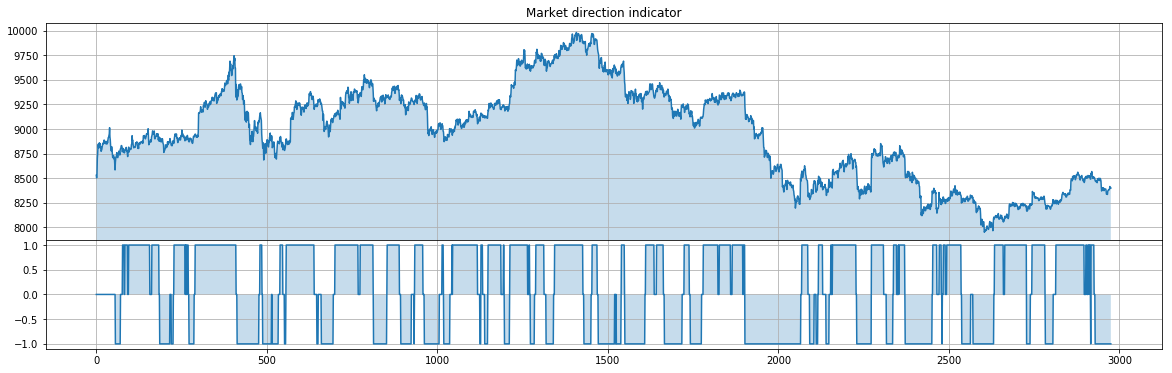

In [16]:
plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
ax0 = plt.subplot(gs[0])
ax0.plot(chart['close'])
ax0.fill_between(chart.index, chart['close'], alpha=0.25)
ax0.set_ylim(0.99*chart['close'].min(), 1.01*chart['close'].max())
ax0.grid()
ax0.set_title('Market direction indicator')
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(chart['direction'])
ax1.fill_between(chart.index, chart['direction'], alpha=0.25)
ax1.grid()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.show()

We are also calculating the Fibonacci levels where the crossover has occured. If we plot the Fibonacci tool into the chart, we can verify if it is implemented correctly.

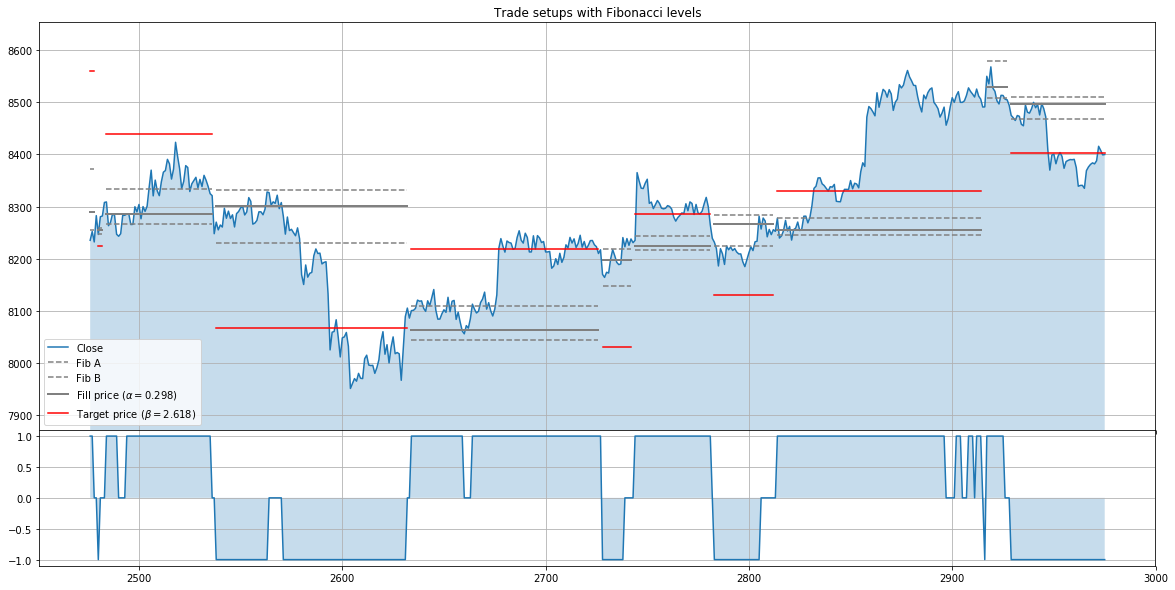

In [17]:
df = pd.DataFrame(chart.tail(min(len(chart.index), 500))).reindex()
plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax0.plot(df['close'])
ax0.plot(df['fib_a'], ls='dashed', color='grey')
ax0.plot(df['fib_b'], ls='dashed', color='grey')
ax0.plot(df['fill_price'], color='grey', lw=2)
ax0.plot(df['fib_c'], color='red')
ax0.fill_between(df.index, df['close'], alpha=0.25)
ax0.set_ylim(0.99*df['close'].min(), 1.01*df['close'].max())
ax0.grid()
ax0.set_title('Trade setups with Fibonacci levels')
ax0.legend(['Close', 'Fib A', 'Fib B'
            , 'Fill price ($\\alpha={:.3f}$)'.format(fib_alpha)
            , 'Target price ($\\beta={:.3f}$)'.format(fib_beta)])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(df['direction'])
ax1.fill_between(df.index, df['direction'], alpha=0.25)
ax1.grid()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.show()

Looking at the plot above we can see that the Fibonacci tool is working as intended. 

## Preliminary analysis

Another thing we can analyze is how a trade is performing. We can calculate the PNL for a trade for a long position by subtracting the fill price from the high. For a short position we can calculate this by subtracting the low from the fill price.

 * Long: $\text{PNL}=\text{High} - \text{Fill price}$
 * Short: $\text{PNL}=\text{Fill price} - \text{Low}$

We will also add the target to the plot, which we use to see if it has been hit. Notice that when a trade is opened, a limit order is placed at $0$. Therefore the line has to cross through $0$, which indicates that the position has been filled.

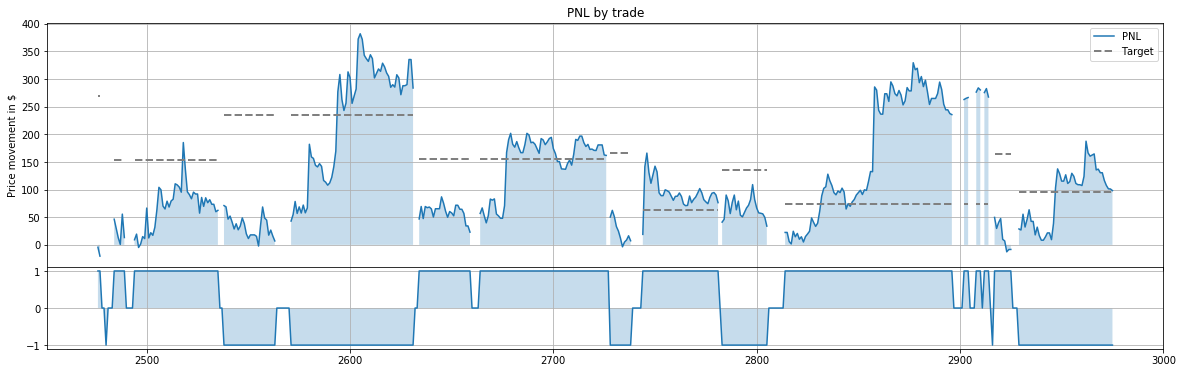

In [18]:
df['trade_pnl'] = df['trade_target'] = NaN
for i in range(min(df.index), max(df.index)+1):
    if df.loc[i, 'direction'] == 1:
        df.loc[i, 'trade_pnl'] = df.loc[i, 'high'] - df.loc[i, 'fill_price']
        df.loc[i, 'trade_target'] = df.loc[i, 'fib_c'] - df.loc[i, 'fill_price']
    if df.loc[i, 'direction'] == -1:
        df.loc[i, 'trade_pnl'] = df.loc[i, 'fill_price'] - df.loc[i, 'low']
        df.loc[i, 'trade_target'] = df.loc[i, 'fill_price'] - df.loc[i, 'fib_c']

plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
plt.plot(df['trade_pnl'])
plt.fill_between(df.index, df['trade_pnl'], alpha=0.25)
plt.plot(df['trade_target'], lw=2, c='grey', ls='dashed')
plt.title('PNL by trade')
ax0.legend(['PNL', 'Target'])
ax0.set_ylabel('Price movement in $')
plt.grid()
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(df['direction'])
ax1.fill_between(df.index, df['direction'], alpha=0.25)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
ax1.grid()

Take into account that the low or high is used to maximize the PNL for the trade. However, because when entering a trade the opposite should be used, for example, if we are long a low will fill our order, and a high goes through the target. Therefore this plot does not accurately reflect if an order is filled or not because we are not using the proper high or low price value.

We should also look at the profit in $ for each target. We will create a bar chart for each of the trade setups that have been generated.

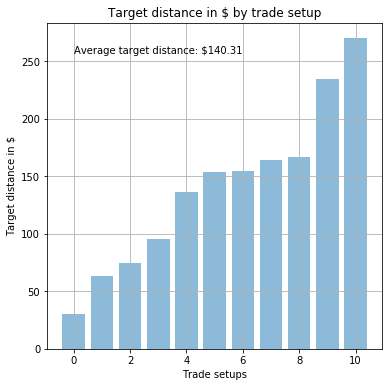

In [19]:
y = sort([i for i in set(df['trade_target']) if str(i) != 'nan'])
x = range(len(y))
plt.figure(figsize=(6,6))
ax = plt.bar(x,y,alpha=0.5)
plt.ylabel('Target distance in $')
plt.xlabel('Trade setups')
plt.title('Target distance in $ by trade setup')
plt.text(0,max(y)*0.95, 'Average target distance: ${:.2f}'.format(sum(y)/len(y)))
plt.grid()
plt.show()

We can see that most setups have a small target distance. With the use of leverage we can perhaps turn this into more profitable trades.

## EMA derivatives

The indicators shows the rate of change of the EMA lines.

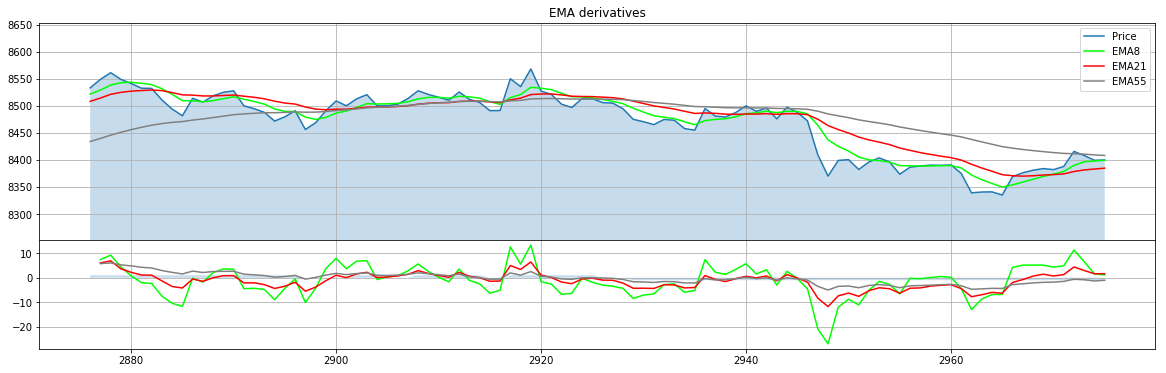

In [20]:
dfdx = pd.DataFrame(chart.tail(min(len(chart.index), 100))).reindex()
dfdx['ema8dx'] = dfdx['ema8'].diff()
dfdx['ema21dx'] = dfdx['ema21'].diff()
dfdx['ema55dx'] = dfdx['ema55'].diff()

plt.figure(figsize=(20,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[2,1])
ax0 = plt.subplot(gs[0])
ax0.plot(dfdx['close'])
ax0.plot(dfdx['ema8'], c='lime')
ax0.plot(dfdx['ema21'], c='r')
ax0.plot(dfdx['ema55'], c='grey')
ax0.fill_between(dfdx.index, dfdx['close'], alpha=0.25)
ax0.set_ylim(0.99*dfdx['close'].min(), 1.01*dfdx['close'].max())
ax0.grid()
ax0.set_title('EMA derivatives')
ax0.legend(['Price', 'EMA8', 'EMA21', 'EMA55'])
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.plot(dfdx['ema8dx'], c='lime')
ax1.plot(dfdx['ema21dx'], c='r')
ax1.plot(dfdx['ema55dx'], c='grey')
ax1.fill_between(dfdx.index, dfdx['direction'], alpha=0.25)
ax1.grid()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.show()

We might want to use this if a trade has hit the target. We simple keep the trade open if the rate of change is positive. When the slope becomes negative we will close the position. This should allow that any momentum that is in a price move to have it play out. This might result in higher PNL for trades. The downside is that we will have to use market orders, which have a fee, to exit our position.

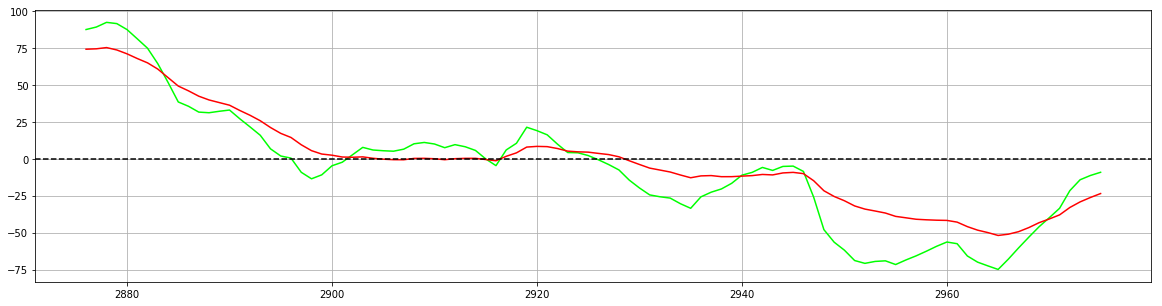

In [21]:
dfdx['dist_ema8'] = dfdx['ema8'] - dfdx['ema55']
dfdx['dist_ema21'] = dfdx['ema21'] - dfdx['ema55']

plt.figure(figsize=(20,5))
plt.plot(dfdx['dist_ema8'],c='lime')
plt.plot(dfdx['dist_ema21'],c='red')
plt.axhline(0, c='black', ls='dashed')
plt.grid()

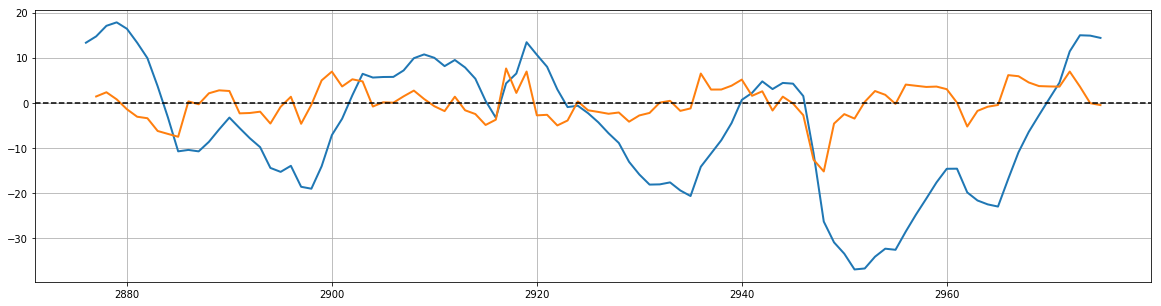

In [22]:
dfdx['dist_ema'] = dfdx['dist_ema8'] - dfdx['dist_ema21']
dfdx['dist_ema_dx'] = dfdx['dist_ema'].diff()
plt.figure(figsize=(20,5))
plt.plot(dfdx['dist_ema'], lw=2)
plt.plot(dfdx['dist_ema_dx'], lw=2)
plt.axhline(0, c='black', ls='dashed')
plt.grid()

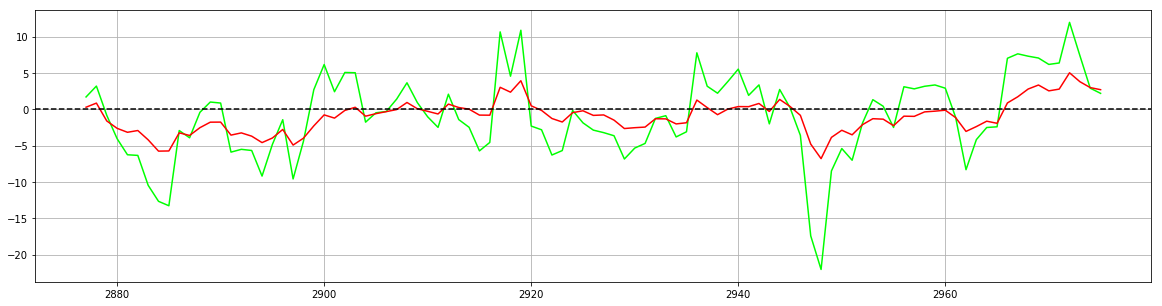

In [23]:
dfdx['dist_ema8_dx'] = dfdx['dist_ema8'].diff()
dfdx['dist_ema21_dx'] = dfdx['dist_ema21'].diff()
plt.figure(figsize=(20,5))
plt.plot(dfdx['dist_ema8_dx'], c='lime')
plt.plot(dfdx['dist_ema21_dx'], c='r')
plt.axhline(0, c='black', ls='dashed')
plt.grid()

# Trading simulation

To have a realistic trading simulation, there are a few factors that we should take into account.

## Seperating training and test data

We want to find the optimal parameters for the data, so we are going to use model fitting. Therefore we have to split the data into training data and test data. We will be using the training data to fit the model. Then we will be using the model on the test data to measure the performance. This will also help us to identify if we are overfitting or underfitting the model.

## Risk management

To implement proper risk management, we are going to introduce the following variables:

 * Position size
 * Stop loss type (`none`, `limit`)
 * Stop loss percentage
 * Leverage

### Stop loss

A stop loss should be placed behind the Fibonacci tool. If we go through this the setup has been invalidated and we should stop out the position.

### Dynamic leveraging

The idea is to scale a trade setup with leverage. When a small trade set up is found, we can scale this into a larger setup by increasing the leverage. This is however still a hypothesis, which should be tested.

This way we can also normalize the trade setups so they are all the same percentage-wise.

### Lot sizing

If we are using dynamic leveraging, we also need dynamic position sizing. If we increase the leverage we are introducing a higher lever of risk. When we scale down our position size, we will be decreasing this introduced risk.

### Liquidation

We should keep in mind that the market can go through unexpected highly volatile periods. This means that the market sometimes can crash a few percent and this could liquidate our position when we are using high leverage. Therefore the automated trading should always be done with a certain % of total balance. The possibility exists that the market can crash, and if all of the available balance is used in trades this can wipe the account.

## Trades

Here we need to calculate our P/L percentage for the entry and exit price of the position. Then we multiply the P/L percentage with the initial order cost to get our gains/losses. Doing it this way properly takes into account that short positions generate gains more quickly.

### Fees

We should also keep track of the fees. When an order is entered we gain a small fee, because this strategy uses a limit order. When a position is closed, it does it with a market order, for which we have to pay a fee. The fee that we will have to pay to Bitmex will be $0.00075-0.00025=0.0005$.

### Extrapolating

With the generated signals for opening a long or short position, and also for closing, we can extrapolate the trades. This is a crucial part where we will use a virtual balance. After each trade this balance is adjusted. This factors in the compounded growth rates. We will also need to apply leverage, calculate the correct fees, take care of stop losses, etc...

# Parameter optimization

We are going to fit the model by finding different parameters for our strategy and risk management. The training data will be used to do the optimization.

## Parameters

The following parameters are going to be optimized:

1. Position size
2. Stop loss fixed-percentage
3. Leverage
4. Different EMA + EMA cross EMA
5. Fibonacci tool $\alpha$, $\beta$

The problem here is that the above paramaters will lead to a combinatorial explosion. A quick estimate is when we do $10$ searches for each variable, we get $10^6=1,000,000$ combinations of parameters to test. A smart solution is required here.

## Quick optimization

We will do a quick search throug the parameters for optimal settings. This will then be used to find an interval on which we do a fine search.

## Fine optimization

After we have found the interval on which we want to do a fine optimization. We can start to find the optimal parameter settings for our model.

# Test run

We are going to test the model on the test data. The model has never seen this data before, and we can see how the optimized parameters will behave in this unknown situation. The results of this will help us to determine if the model is correct, or over/under fitting.

# Performance

We are going to analyze the result of the strategy for the training and test data. We will put more emphasis on the test data because it will more realistically show us how the strategy performs in the real world.

## Equity curve

We will begin by looking at the equity curve, which is simply our balance. An important thing to notice is the drawdown that the strategy gives.

## Drawdown

We should use a strategy which gives a certain level of drawdown. This is important because when we are going to use a live trading bot which implements this strategy, we need a fail safe mechanism. If the drawdown of the bot ever exceeds the drawdown of the backtest, we will shut it down. The results should be analyzed later on when the chart has played out. 

## Statistics

More detailed statistics which goes into the trades.

1. Trades, win rate, ...
2. Histograms of the various variables
3. ...

# Conclusion

We can conclude that this strategy, ...